# 1. Import Libraries and Tools

In [1]:
import os # For directory and file operations
import numpy as np # For numerical operations and handling image arrays
import tensorflow as tf # For numerical operations and handling image arrays
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img # for loading image, image preprocessing, data augmentation
from tensorflow.keras.models import Sequential # For building model architechture
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization # For model layers
from tensorflow.keras.applications import VGG16 # For using VGG16 model
from tensorflow.keras.optimizers import Adam # For optimizer
from sklearn.metrics import confusion_matrix, classification_report
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Loading Dataset

In [2]:
# Directories for training and testing data
train_dir = "/kaggle/input/melanoma-cancer-dataset/train"
test_dir = "/kaggle/input/melanoma-cancer-dataset/test"

# Image size and Batch size
img_width, img_height = 224, 224
batch_size = 32

# Data Augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale = 1./255, # Rescale the image by normalizing it
    rotation_range = 50, # Rotate the image by 30 degrees
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.3, # Shear means cutting away part of the image (max 30%)
    zoom_range = 0.3,
    horizontal_flip = True, # Allow horizontal flipping
    fill_mode = "nearest",
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(rescale= 1./255)

# Training and testing generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary' # Binary Classification: Benign vs Malignant
    
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
    
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

# Print Class labels
print("Class Mapping:",train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


# 3. Data Visualization

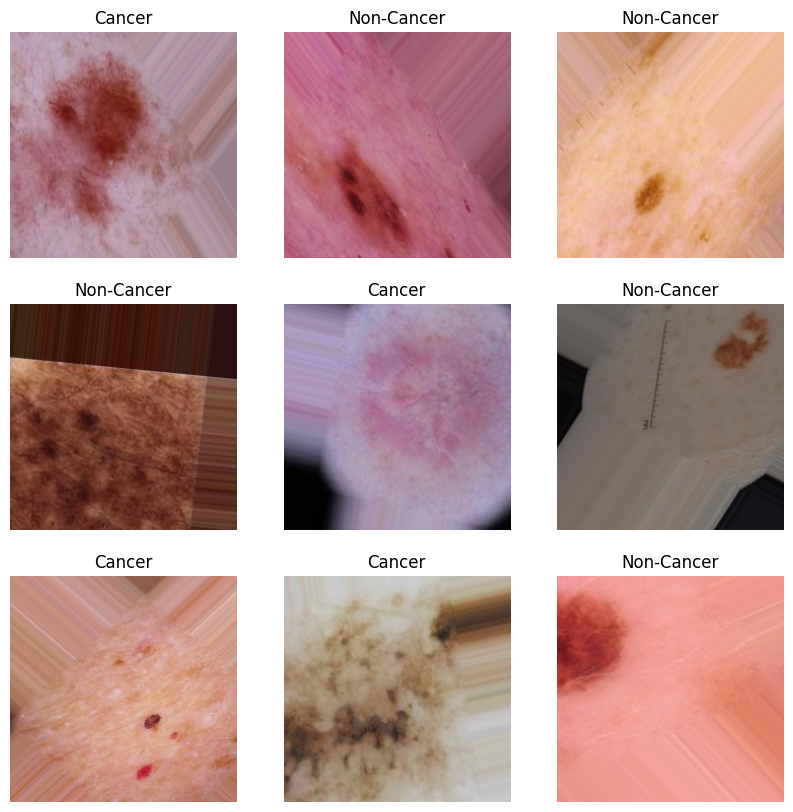

In [3]:
def plot_images(generator):
    class_names = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        plt.title('Cancer' if labels[i] == 1 else 'Non-Cancer')
        plt.axis('off')
    plt.show()

plot_images(train_generator)

# 4. Applying VGG16 Model for Transfer Learning

The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

- First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 224x224 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

- Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

- Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

- After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

- Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

- Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

- After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

- Next, another Dropout layer is added with model.add(Dropout(0.2))

- Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.

In [12]:
# Loading base model
base_model = VGG16(weights= 'imagenet', include_top = False, input_shape = (img_width, img_height, 3))

# Freezing initial layers of base model
for layer in base_model.layers[:15]:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Building the final model
model = Sequential() 
model.add(base_model) # Add VGG16 base model
model.add(Flatten()) # Flatten the output of base 
model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Dense layer with Relu activation 
model.add(BatchNormalization())
model.add(Dropout(0.5)) # Here we randomly turn off 50% of neurons.
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Dense layer with Relu activation 
model.add(BatchNormalization())
model.add(Dropout(0.5)) # Here we randomly turn off 50% of neurons.
#model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Dense layer with Relu activation 
#model.add(BatchNormalization())
#model.add(Dropout(0.5)) # Here we randomly turn off 50% of neurons.
#model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Dense layer with Relu activation 
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid")) # Dense layer with Sigmoid activation

# Compile the model
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics= ['accuracy'])

# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
   # callbacks = [early_stopping, reduce_lr]
)


Epoch 1/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 260s 682ms/step - accuracy: 0.7736 - loss: 17.0899 - val_accuracy: 0.8144 - val_loss: 7.8818
Epoch 2/5
  1/371 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.8750 - loss: 7.8359

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 7.8359 - val_accuracy: 0.7143 - val_loss: 8.0830
Epoch 3/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 254s 679ms/step - accuracy: 0.8259 - loss: 6.8729 - val_accuracy: 0.8563 - val_loss: 4.6945
Epoch 4/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.8125 - loss: 4.8728 - val_accuracy: 0.8571 - val_loss: 4.6303
Epoch 5/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 252s 673ms/step - accuracy: 0.8355 - loss: 4.2772 - val_accuracy: 0.8629 - val_loss: 3.0902


# 5. Training and Validation Plots

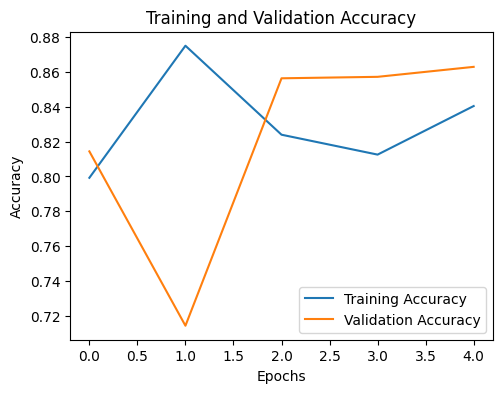

In [13]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
   
    epochs_range = range(len(acc))

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label= "Training Accuracy")
    plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.show()

plot_training_history(history)

# 6. Evaluating Model Performance (Confusion Matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8882 - loss: 3.0467
Test Loss: 3.0539286136627197
Test Accuracy: 0.8865000009536743
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step


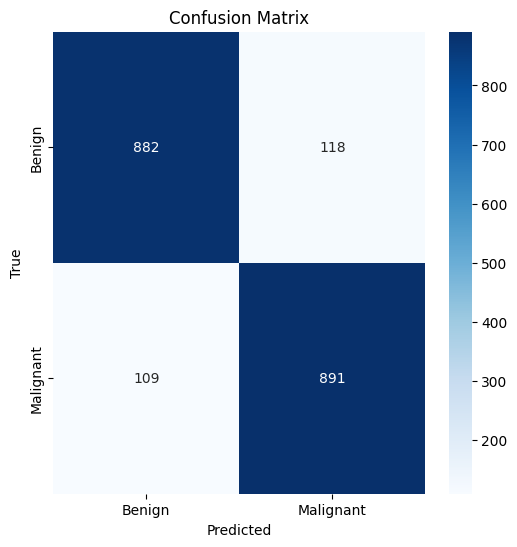

In [14]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype("int32") # Convert probabilities to binary predictions
y_true = test_generator.classes # True labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar= True, xticklabels = ['Benign', 'Malignant'], yticklabels = ['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 7.  Evaluating Model Performance (Classification Report)

In [15]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.88      0.89      1000
   Malignant       0.88      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



# 8. Save the Model

In [16]:
# Save the entire model
model.save("model.h5")

# 8. Prediction System

In [17]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/model.h5")

def predict_skin_cancer(image_path, model):
    img = load_img(image_path, target_size = (img_width, img_height))
    img_array = img_to_array(img) / 255
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make predictions
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
        
    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


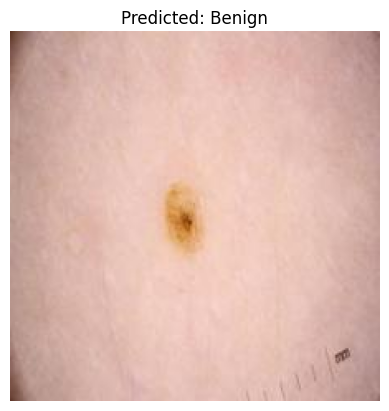

In [18]:
# Test on new image 
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Benign/6313.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


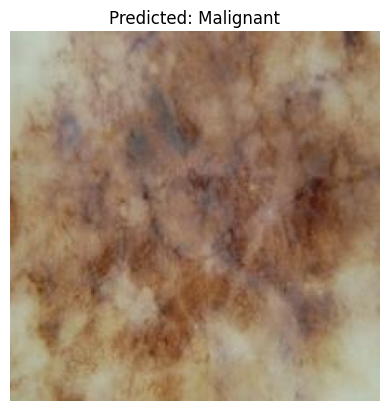

In [19]:
# Test on new image 
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/train/Malignant/1024.jpg", model)